# Wallet Risk Scoring (Compound V2)

# IMPORT REQUIRED LIBRARIES



In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# LOAD THE DATA

In [30]:
# Read the data
f=pd.read_csv('borrow.csv')

In [31]:
# print the data
df.head()

,wallet_id,evt_block_time,accountBorrows,borrowAmount,borrower,totalBorrows,liquidator,repayAmount,mintAmount,mintTokens,minter,redeemAmount,redeemTokens,redeemer,asset_symbol,ctoken_address,decimals_mantissa
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,29-06-2020 19:04,2.450000e+20,2.450000e+20,0xc54b6a9da95f880c4525020428ee10edd9d93a3a,1.100000e+27,0x796d37daf7cdc455e023be793d0daa6240707069,5.930000e+16,1.000000e+15,4.978222e+06,0x316110a635d150e2d6a1cc8148268bb482146a05,1.090000e+16,5.412103e+07,0x5141b82f5ffda4c6fe1e372978f1c5427640a190,AAVE,0xe65cdb6479bac1e22340e4e755fae7e509ecd06c,1.000000e+18
1,0x06b51c6882b27cb05e712185531c1f74996dd988,28-02-2021 19:44,2.840000e+23,1.000000e+22,0x3d1a8bf4b5db60f71386f1e714c1402ba9476242,3.150000e+25,0x796d37daf7cdc455e023be793d0daa6240707069,2.070000e+17,2.800000e+18,1.393902e+10,0x22dd67aaab8a51adc1ccb23b98758c878281fa10,6.650000e+15,3.309793e+07,0x5141b82f5ffda4c6fe1e372978f1c5427640a190,BAT,0x6c8c6b02e7b2be14d4fa6022dfd6d75921d90e4e,1.000000e+18
2,0x0795732aacc448030ef374374eaae57d2965c16c,08-07-2020 03:32,5.000000e+21,5.000000e+21,0x06cb7c24990cbe6b9f99982f975f9147c000fec6,4.470000e+24,0x796d37daf7cdc455e023be793d0daa6240707069,8.040000e+16,5.900000e+17,2.937149e+09,0x660a6d7ee594b207139999cdd8f03217d193c7fa,7.000000e+15,3.482228e+07,0x5141b82f5ffda4c6fe1e372978f1c5427640a190,COMP,0x70e36f6bf80a52b3b46b3af8e106cc0ed743e8e4,1.000000e+18
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,05-10-2019 04:39,5.600000e+21,5.600000e+21,0xceb9e948ce562b3b3eaa2495e39841a62815a524,2.720000e+23,0xda7d7a4640dfd472d243dceadf40d0e1db891afb,6.760000e+12,1.000000e+15,4.978217e+06,0xb98d4d4e205aff4d4755e9df19bd0b8bd4e0f148,9.810000e+17,4.896720e+09,0x73c8daa956e84b0a312a85caae2e01a74373e106,DAI,0x5d3a536e4d6dbd6114cc1ead35777bab948e3643,1.000000e+18
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,01-07-2020 23:37,2.720000e+26,1.450000e+25,0x3ba21b6477f48273f41d241aa3722ffb9e07e247,1.120000e+27,0xda7d7a4640dfd472d243dceadf40d0e1db891afb,1.800000e+16,2.590000e+15,1.288860e+07,0x6c984f5db9d80df55952d087d87d7808d4ed7915,2.900000e+18,1.448150e+10,0xbe625e5055aa83748e67dae0ca8609729e01bde5,WETH,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,1.000000e+18


In [32]:
# Select all numerical columns
col_names=['borrowAmount','totalBorrows','repayAmount','mintAmount','mintTokens','redeemAmount','redeemTokens']

In [33]:
# Convert non numeric values
for col in cols:
    df[col]=pd.to_numeric(df[col],errors='coerce')


# GROUP THE DATA

In [34]:
# Aggregate the wallet level data
# For each wallet summarize its behaviour
agg_df=df.groupby('wallet_id').agg({
    'borrowAmount': 'sum',
    'totalBorrows': 'max',
    'repayAmount': 'sum',
    'mintAmount': 'sum',
    'mintTokens': 'sum',
    'redeemAmount': 'sum',
    'redeemTokens': 'sum'
}).fillna(0)




# COMPUTE THE SCORE

In [35]:
# Compute logic-based score
""" Here it means borrowing increases the rish and repayment reduces the risk"""
agg_df['raw_score']=(
    agg_df['borrowAmount']*0.5+agg_df['totalBorrows']*0.3-agg_df['repayAmount']*0.4-agg_df['redeemAmount']*0.2)



# SPLIT THE DATA

In [36]:
# Divide wallet into 1000 buckets
agg_df['risk_label']=pd.qcut(agg_df['raw_score'],q=1000,labels=False,duplicates='drop')
X = agg_df[col_names]
y = agg_df['risk_label'].astype(int)

In [37]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TRAIN THE MODEL

In [38]:
model=RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

# PREDICTION

In [43]:
# Predict and normalize to 0-1000
agg_df['score']=model.predict(X)
score=agg_df['score']
agg_df['score']=((score - score.min()) / (score.max() - score.min()) * 1000).round().astype(int)

# EXPORT CSV

In [44]:
result=agg_df[['score']].reset_index()
result.to_csv('wallet_risk_score.csv',index=False)


# PLOT




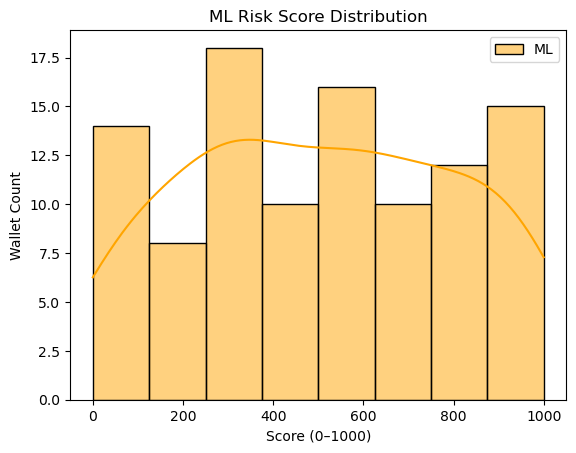

In [45]:
sns.histplot(result['score'], color='orange', label='ML', kde=True)
plt.legend()
plt.title("ML Risk Score Distribution")
plt.xlabel("Score (0–1000)")
plt.ylabel("Wallet Count")
plt.show()

In [46]:
# Preview
print(result.head())

                                    wallet_id  score
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3    990
1  0x06b51c6882b27cb05e712185531c1f74996dd988    535
2  0x0795732aacc448030ef374374eaae57d2965c16c    397
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9    271
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae    982
